# 네이버 영화 리뷰 감성 분류하기

모델은 고정해두고   
(1) 데이터 양을 다르게 하고 (절반/전체)   
(2) 전처리를 다르게 해서 (불용어 처리 유무, oov를 전체/일부/최소)  
다양한 전처리 단계를 통해 분석량 변화  

### 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re # 정규 표현식 관련 모델
from konlpy.tag import Okt #Open Korean Text 형태소 분리 모듈
from tqdm import tqdm # 진행 상황을 보여주는 모듈

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 한글 깨짐 방지
import platform

if platform.system() == 'Windows': 
    path = r'c:\Windows\Fonts\gulim.ttf'
elif platform.system() == 'Darwin': # Mac OS
    path = r'/System/Library/Fonts/AppleGothic'
else:
    path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

##### [1] 데이터 로드하기

In [ ]:
data = pd.read_table('/content/drive/MyDrive/data.txt')

In [ ]:
data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


##### [2] 데이터 정제하기

[2 - 1] 정규식을 통한 한글과 공백을 제외한 문자 제거

In [ ]:
data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


[2 - 2] 중복 유무 확인

In [ ]:
# document열의 중복여부 확인
print('전체 데이터 :', len(data))
print('고유값 :', data['document'].nunique())

전체 데이터 : 150000
고유값 : 143682


전체 데이터에서 고유값과 차이가 난다는 것은 그만큼의 중복값이 있다는 것이니 제거한다

In [ ]:
# 중복 데이터 제거
data.drop_duplicates(subset=['document'], inplace = True)

[2 - 3] 결측치 확인

In [ ]:
data.isna().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
# 결측 데이터 확인
data.loc[data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
# 결측치 제거
data = data.dropna(how = 'any')

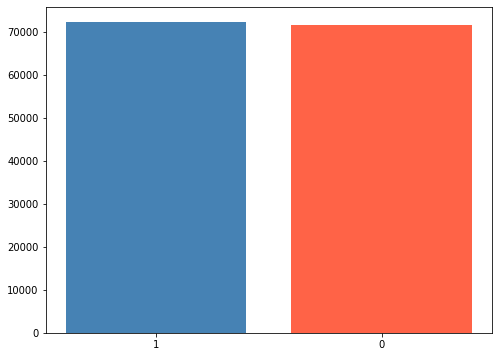

   label  count
0      0  72216
1      1  71466


In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['1', '0'], data['label'].value_counts(), color = ['steelblue', 'tomato'])
plt.show()

print(data.groupby('label').size().reset_index(name = 'count'))

거의 같은 데이터 자료로 구성되어 있음

##### [3] 토큰화

[3 - 1] 불용어 제거

https://www.ranks.nl/stopwords/korean

참고) 기본적인 한국어 불용어 리스트 100개
- https://bab2min.tistory.com/544
    * 단, 이 리스트는 구어나 인터넷의 가벼운 글들을 반영하지 않아서 블로그/SNS 등에는 적합하지 않음

**불용어 지정 - 분기 (1)**

In [ ]:
with open("/content/drive/MyDrive/stopwords.txt", "r", encoding = "utf-8") as f:
    stopwords = f.readlines()
    stopwords = stopwords[0].split(" ")

In [ ]:
print(len(stopwords))
print(stopwords[:20])

889
['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다']


889개의 불용어로 구성되어 있는데 조금 지나치게 많은거 아닌가?

In [ ]:
stopwords_01 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
# 토큰화만 형태소로 진행된 경우
X_train_00 = []
# 토큰화와 불용어 적게 제거한 경우
X_train_01 = []
# 토큰화와 형태소, 불용어 많이 제거한 경우
X_train_02 = []

# 00
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    X_train_00.append(tokenized_sentence)

# 01
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_01] # 불용어 적게 제거
    X_train_01.append(stopwords_removed_sentence)

# 02
for sentence in tqdm(data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 많이 제거
    X_train_02.append(stopwords_removed_sentence)

100%|██████████| 143682/143682 [15:01<00:00, 159.45it/s]


##### [4] 정수 인코딩

In [ ]:
# 각각의 데이터에 대한 Tokenizer 생성
tokenizer_0 = Tokenizer()
tokenizer_1 = Tokenizer()
tokenizer_2 = Tokenizer()
# 각각의 Tokenizer 훈련
tokenizer_0.fit_on_texts(X_train_00)
tokenizer_1.fit_on_texts(X_train_01)
tokenizer_2.fit_on_texts(X_train_02)

In [ ]:
print('불용어를 제거하지 않는 경우  :', len(tokenizer_0.word_index))
print('불용어를 일부만 제거한 경우  :', len(tokenizer_1.word_index))
print('불용어를 많이 제거한 경우    :', len(tokenizer_2.word_index))

불용어를 제거하지 않는 경우  : 43770
불용어를 일부만 제거한 경우  : 43752
불용어를 많이 제거한 경우    : 43431


In [ ]:
def checkToken(tokenizer, threshold) :
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value
    

    total = (rare_freq / total_freq)*100

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    return (rare_freq / total_freq) * 100

**분기점 2 - 희귀 단어 수 설정**

In [ ]:
num_pro_0_30 = checkToken(tokenizer_0, 30)
print('------------------------------')
num_pro_0_3 = checkToken(tokenizer_0, 3)
print('------------------------------')
num_pro_1_30 = checkToken(tokenizer_1, 30)
print('------------------------------')
num_pro_1_3 = checkToken(tokenizer_1, 3)
print('------------------------------')
num_pro_2_30 = checkToken(tokenizer_2, 30)
print('------------------------------')
num_pro_2_3 = checkToken(tokenizer_2, 3)

list_pro_30 = []
list_pro_3 = []

list_pro_30.append(num_pro_0_30)
list_pro_30.append(num_pro_1_30)
list_pro_30.append(num_pro_2_30)
list_pro_3.append(num_pro_0_3)
list_pro_3.append(num_pro_1_3)
list_pro_3.append(num_pro_2_3)

단어 집합(vocabulary)의 크기 : 43770
등장 빈도가 30번 미만인 희귀 단어의 수: 39276
단어 집합에서 희귀 단어의 비율: 89.73269362577108
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.339727969798032
------------------------------
단어 집합(vocabulary)의 크기 : 43770
등장 빈도가 3번 미만인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.608864519076995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5747898974035586
------------------------------
단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 30번 미만인 희귀 단어의 수: 39276
단어 집합에서 희귀 단어의 비율: 89.76961053208996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.933426758471379
------------------------------
단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 3번 미만인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.631742548912044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8757278609673573
------------------------------
단어 집합(vocabulary)의 크기 : 43431
등장 빈도가 30번 미만인 희귀 단어의 수: 39189
단어 집합에서 희귀 단어의 비율: 90.23278303515922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.946876212679722
------------------------------
단어 집합(vocabulary)의 크기 : 43431
등장 빈도가 3번 미만인 희귀 단어의 수: 24307
단어 집합에서 희귀 단어의 비율: 55.966936059496675
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.

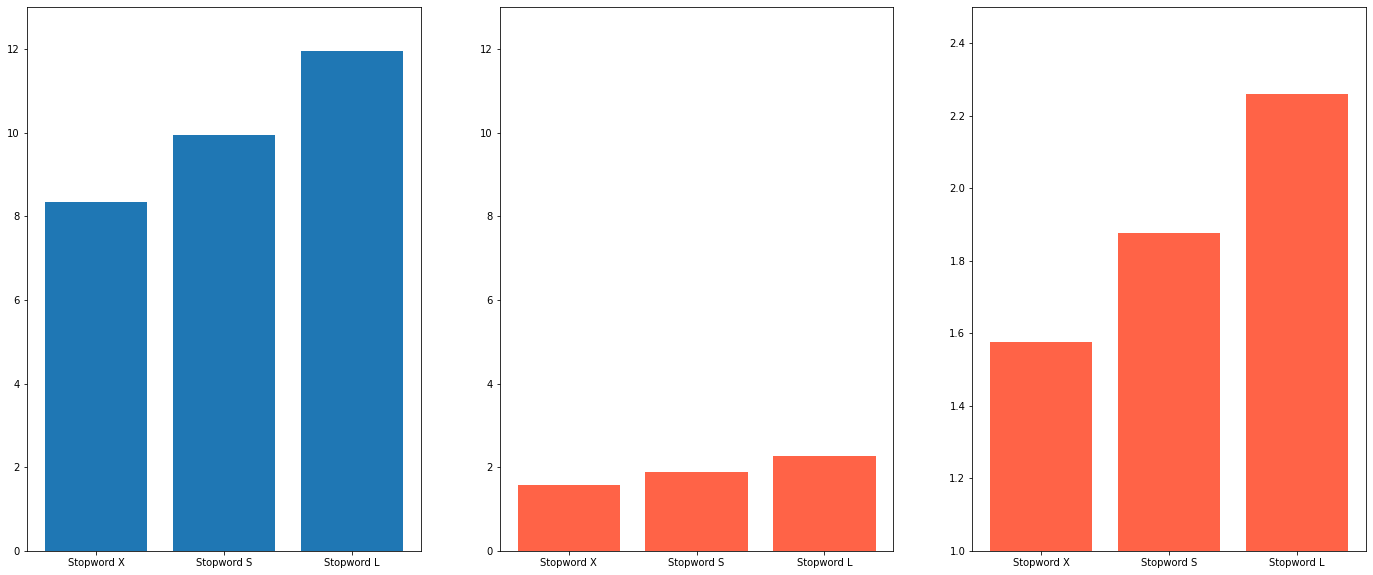

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(131)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_30)
plt.ylim(0,13)
plt.subplot(132)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_3, color = 'tomato')
plt.ylim(0,13)
plt.subplot(133)
plt.bar(['Stopword X', 'Stopword S', 'Stopword L'], list_pro_3, color = 'tomato')
plt.ylim(1,2.5)
plt.show()

In [ ]:
total_cnt_0 = 43770
total_cnt_1 = 43752
total_cnt_2 = 43431

rare_cnt_0_1  = 39276
rare_cnt_0_2  = 24340

rare_cnt_1_1  = 39189
rare_cnt_1_2  = 24307

vocab_size_0_00 = total_cnt_0 + 1
vocab_size_0_03 = total_cnt_0 - rare_cnt_0_1 + 1
vocab_size_0_30 = total_cnt_0 - rare_cnt_0_2 + 1

vocab_size_1_00 = total_cnt_1 + 1
vocab_size_1_03 = total_cnt_1 - rare_cnt_0_1 + 1
vocab_size_1_30 = total_cnt_1 - rare_cnt_0_2 + 1

vocab_size_2_00 = total_cnt_2 + 1
vocab_size_2_03 = total_cnt_2 - rare_cnt_1_1 + 1
vocab_size_2_30 = total_cnt_2 - rare_cnt_1_2 + 1

print(vocab_size_0_00)
print(vocab_size_0_03)
print(vocab_size_0_30)
print(vocab_size_1_00)
print(vocab_size_1_03)
print(vocab_size_1_30)
print(vocab_size_2_00)
print(vocab_size_2_03)
print(vocab_size_2_30)

43771
4495
19431
43753
4477
19413
43432
4243
19125


텍스트 시퀀스를 정수 시퀀스로 변환

In [ ]:
tokenizer_0_0 = Tokenizer(vocab_size_0_00)
tokenizer_0_3 = Tokenizer(vocab_size_0_03)
tokenizer_0_30 = Tokenizer(vocab_size_0_30)
tokenizer_1_0 = Tokenizer(vocab_size_1_00)
tokenizer_1_3 = Tokenizer(vocab_size_1_03)
tokenizer_1_30 = Tokenizer(vocab_size_1_30)
tokenizer_1_0 = Tokenizer(vocab_size_2_00)
tokenizer_1_3 = Tokenizer(vocab_size_2_03)
tokenizer_1_30 = Tokenizer(vocab_size_2_30)

In [ ]:
X_train_0_00 = tokenizer_0_0.fit_on_texts(X_train_00)
X_train_0_03 = tokenizer_0_3.fit_on_texts(X_train_00)
X_train_0_30 = tokenizer_0_30.fit_on_texts(X_train_00)
X_train_1_00 = tokenizer_1_0.fit_on_texts(X_train_01)
X_train_1_03 = tokenizer_1_3.fit_on_texts(X_train_01)
X_train_1_30 = tokenizer_1_30.fit_on_texts(X_train_01)
X_train_2_00 = tokenizer_1_0.fit_on_texts(X_train_02)
X_train_2_03 = tokenizer_1_3.fit_on_texts(X_train_02)
X_train_2_30 = tokenizer_1_30.fit_on_texts(X_train_02)

In [ ]:
X_train_0_00 = tokenizer_0_0.texts_to_sequences(X_train_00)
X_train_0_03 = tokenizer_0_3.texts_to_sequences(X_train_00)
X_train_0_30 = tokenizer_0_30.texts_to_sequences(X_train_00)
X_train_1_00 = tokenizer_1_0.texts_to_sequences(X_train_01)
X_train_1_03 = tokenizer_1_3.texts_to_sequences(X_train_01)
X_train_1_30 = tokenizer_1_30.texts_to_sequences(X_train_01)
X_train_2_00 = tokenizer_1_0.texts_to_sequences(X_train_02)
X_train_2_03 = tokenizer_1_3.texts_to_sequences(X_train_02)
X_train_2_30 = tokenizer_1_30.texts_to_sequences(X_train_02)

In [ ]:
y_train = np.array(data['label'])

In [ ]:
len(y_train)

143682

[5] 빈 샘플 제거

In [ ]:
drop_train_0_00 = [index for index, sentence in enumerate(X_train_0_00) if len(sentence) < 1]
drop_train_0_03 = [index for index, sentence in enumerate(X_train_0_03) if len(sentence) < 1]
drop_train_0_30 = [index for index, sentence in enumerate(X_train_0_30) if len(sentence) < 1]

drop_train_1_00 = [index for index, sentence in enumerate(X_train_1_00) if len(sentence) < 1]
drop_train_1_03 = [index for index, sentence in enumerate(X_train_1_03) if len(sentence) < 1]
drop_train_1_30 = [index for index, sentence in enumerate(X_train_1_30) if len(sentence) < 1]

drop_train_2_00 = [index for index, sentence in enumerate(X_train_2_00) if len(sentence) < 1]
drop_train_2_03 = [index for index, sentence in enumerate(X_train_2_03) if len(sentence) < 1]
drop_train_2_30 = [index for index, sentence in enumerate(X_train_2_30) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train_0_00 = np.delete(X_train_0_00, drop_train_0_00, axis=0)
X_train_0_03 = np.delete(X_train_0_03, drop_train_0_03, axis=0)
X_train_0_30 = np.delete(X_train_0_30, drop_train_0_30, axis=0)
X_train_1_00 = np.delete(X_train_1_00, drop_train_1_00, axis=0)
X_train_1_03 = np.delete(X_train_1_03, drop_train_1_03, axis=0)
X_train_1_30 = np.delete(X_train_1_30, drop_train_1_30, axis=0)
X_train_2_00 = np.delete(X_train_2_00, drop_train_2_00, axis=0)
X_train_2_03 = np.delete(X_train_2_03, drop_train_2_03, axis=0)
X_train_2_30 = np.delete(X_train_2_30, drop_train_2_30, axis=0)

print(len(X_train_0_00))
print(len(X_train_0_03))
print(len(X_train_0_30))
print(len(X_train_1_00))
print(len(X_train_1_03))
print(len(X_train_1_30))
print(len(X_train_2_00))
print(len(X_train_2_03))
print(len(X_train_2_30))

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


143660
143001
143447
143650
142882
143428
143492
142436
143199


In [ ]:
y_train_0_00 = np.delete(y_train, drop_train_0_00, axis=0)
y_train_0_03 = np.delete(y_train, drop_train_0_03, axis=0)
y_train_0_30 = np.delete(y_train, drop_train_0_30, axis=0)
y_train_1_00 = np.delete(y_train, drop_train_1_00, axis=0)
y_train_1_03 = np.delete(y_train, drop_train_1_03, axis=0)
y_train_1_30 = np.delete(y_train, drop_train_1_30, axis=0)
y_train_2_00 = np.delete(y_train, drop_train_2_00, axis=0)
y_train_2_03 = np.delete(y_train, drop_train_2_03, axis=0)
y_train_2_30 = np.delete(y_train, drop_train_2_30, axis=0)

print(len(y_train_0_00))
print(len(y_train_0_03))
print(len(y_train_0_30))
print(len(y_train_1_00))
print(len(y_train_1_03))
print(len(y_train_1_30))
print(len(y_train_2_00))
print(len(y_train_2_03))
print(len(y_train_2_30))

143660
143001
143447
143650
142882
143428
143492
142436
143199


In [ ]:
print(len(y_train))

143682


[6] 패딩

In [ ]:
# 데이터의 길이 확인
def checkLen(X_data) :
  list_len = []
  for i in range(0, len(X_data)):
      list_len.append(len(X_data[i]))
    
  print('리뷰의 최대 길이 :', max(list_len))
  print('리뷰의 평균 길이 :', np.mean(list_len))
  print('리뷰의 중간 값 길이 :', np.median(list_len))
  return list_len

In [ ]:
list_len_0_00 = checkLen(X_train_0_00)

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 13.234950577753027
리뷰의 중간 값 길이 : 10.0


In [ ]:
list_len_2_30 = checkLen(X_train_2_30)

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 9.017102074735158
리뷰의 중간 값 길이 : 7.0


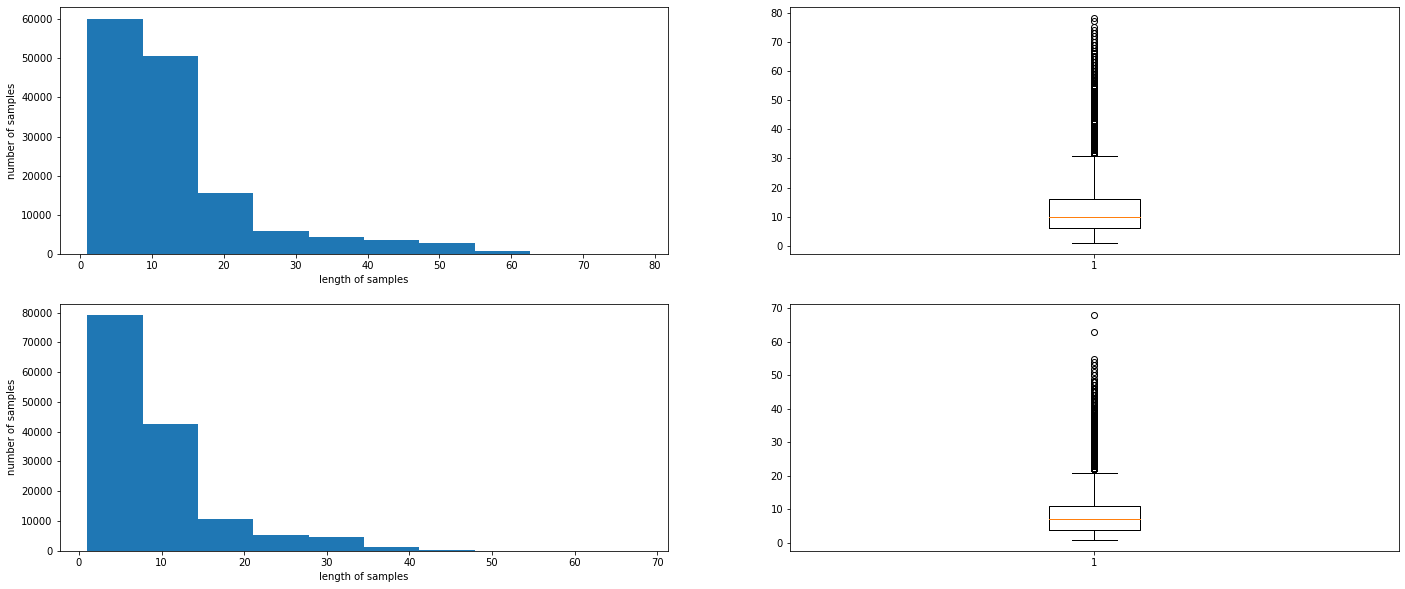

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(2,2,1)
plt.hist(list_len_0_00)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(2,2,2)
plt.boxplot(list_len_0_00)

plt.subplot(2,2,3)
plt.hist(list_len_2_30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(2,2,4)
plt.boxplot(list_len_2_30)
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print(nested_list,'전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
below_threshold_len(40, X_train_0_00)

[list([64, 473, 27, 278, 677])
 list([965, 474, 54, 620, 2, 230, 1466, 37, 979, 694, 31])
 list([403, 2460, 25033, 2330, 5684, 3, 237, 21, 19]) ...
 list([1, 51, 74, 68, 1465, 13, 5615, 14641, 56, 10481, 10417, 13, 1061])
 list([1057, 2, 5, 2282, 2946, 35, 1250, 558, 10, 5, 7864])
 list([212, 2, 1836, 29, 43770, 4, 72, 1, 1374, 2])] 전체 샘플 중 길이가 40 이하인 샘플의 비율: 95.1921202840039


In [ ]:
below_threshold_len(40, X_train_2_30)

[list([429, 12, 235, 607]) list([905, 430, 26, 558, 1, 1427, 17, 623])
 list([2415, 2288, 5654, 2, 196, 8]) ...
 list([24, 47, 39, 1426, 13, 5585, 14614, 28, 10445, 10381, 13, 1009])
 list([1005, 1, 2236, 2904, 1208, 508, 7834])
 list([174, 1, 1790, 45, 1337, 1])] 전체 샘플 중 길이가 40 이하인 샘플의 비율: 99.84636764223214


In [ ]:
max_len = 40

X_data_0_00 = pad_sequences(X_train_0_00, maxlen = max_len)
X_data_0_03 = pad_sequences(X_train_0_03, maxlen = max_len)
X_data_0_30 = pad_sequences(X_train_0_30, maxlen = max_len)
X_data_1_00 = pad_sequences(X_train_1_00, maxlen = max_len)
X_data_1_03 = pad_sequences(X_train_1_03, maxlen = max_len)
X_data_1_30 = pad_sequences(X_train_1_30, maxlen = max_len)
X_data_2_00 = pad_sequences(X_train_2_00, maxlen = max_len)
X_data_2_03 = pad_sequences(X_train_2_03, maxlen = max_len)
X_data_2_30 = pad_sequences(X_train_2_30, maxlen = max_len)

In [ ]:
embedding_dim = 100
hidden_units = 128

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [ ]:
def checkModel(X_train, y_train, vocab_size, name):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(LSTM(hidden_units))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

  name = (f'{name}.h5')
  mc = ModelCheckpoint('.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

  history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)
  return history

In [ ]:
history_0_00 = checkModel(X_data_0_00, y_train_0_00, vocab_size_0_00, 'X_data_0_00')
history_0_03 = checkModel(X_data_0_03, y_train_0_03, vocab_size_0_03, 'X_data_0_03')
history_0_30 = checkModel(X_data_0_30, y_train_0_30, vocab_size_0_30, 'X_data_0_30')

history_1_00 = checkModel(X_data_1_00, y_train_1_00, vocab_size_1_00, 'X_data_1_00')
history_1_03 = checkModel(X_data_1_03, y_train_1_03, vocab_size_1_03, 'X_data_1_03')
history_1_30 = checkModel(X_data_1_30, y_train_1_30, vocab_size_1_30, 'X_data_1_30')

history_2_00 = checkModel(X_data_2_00, y_train_2_00, vocab_size_2_00, 'X_data_2_00')
history_2_03 = checkModel(X_data_2_03, y_train_2_03, vocab_size_2_03, 'X_data_2_03')
history_2_30 = checkModel(X_data_2_30, y_train_2_30, vocab_size_2_30, 'X_data_2_30')

Epoch 1/15
1796/1796 [==============================] - ETA: 0s - loss: 0.3860 - acc: 0.8230
Epoch 1: val_acc improved from -inf to 0.85052, saving model to .h5
1796/1796 [==============================] - 265s 143ms/step - loss: 0.3860 - acc: 0.8230 - val_loss: 0.3418 - val_acc: 0.8505
Epoch 2/15
1796/1796 [==============================] - ETA: 0s - loss: 0.2838 - acc: 0.8802
Epoch 2: val_acc improved from 0.85052 to 0.85309, saving model to .h5
1796/1796 [==============================] - 253s 141ms/step - loss: 0.2838 - acc: 0.8802 - val_loss: 0.3474 - val_acc: 0.8531
Epoch 3/15
1796/1796 [==============================] - ETA: 0s - loss: 0.2270 - acc: 0.9072
Epoch 3: val_acc did not improve from 0.85309
1796/1796 [==============================] - 257s 143ms/step - loss: 0.2270 - acc: 0.9072 - val_loss: 0.3850 - val_acc: 0.8491
Epoch 4/15
1796/1796 [==============================] - ETA: 0s - loss: 0.1808 - acc: 0.9274
Epoch 4: val_acc did not improve from 0.85309
1796/1796 [=====

In [ ]:
df_history = pd.DataFrame([history_0_00.history['val_acc'], history_0_03.history['val_acc'], history_0_30.history['val_acc'], 
                           history_1_00.history['val_acc'], history_1_03.history['val_acc'], history_1_30.history['val_acc'], 
                           history_2_00.history['val_acc'], history_2_03.history['val_acc'], history_2_30.history['val_acc'],
                           history_0_00.history['acc'], history_0_03.history['acc'], history_0_30.history['acc'], 
                           history_1_00.history['acc'], history_1_03.history['acc'], history_1_30.history['acc'], 
                           history_2_00.history['acc'], history_2_03.history['acc'], history_2_30.history['acc']]).T

In [ ]:
list_index = ['X_0_00', 'X_0_03', 'X_0_30',
              'X_1_00', 'X_1_03', 'X_1_30',
              'X_2_00', 'X_2_03', 'X_2_30']

In [ ]:
list_val_acc = df_history.loc[:,:8]
list_acc = df_history.loc[:,9:]

In [ ]:
def checkMax(data):
  list_acc = []
  for i in range(0, len(data.columns)) :
    list_acc.append(max(data.iloc[:, i]))
  return list_acc

In [ ]:
list_v_a = checkMax(list_val_acc)

In [ ]:
list_a = checkMax(list_acc)

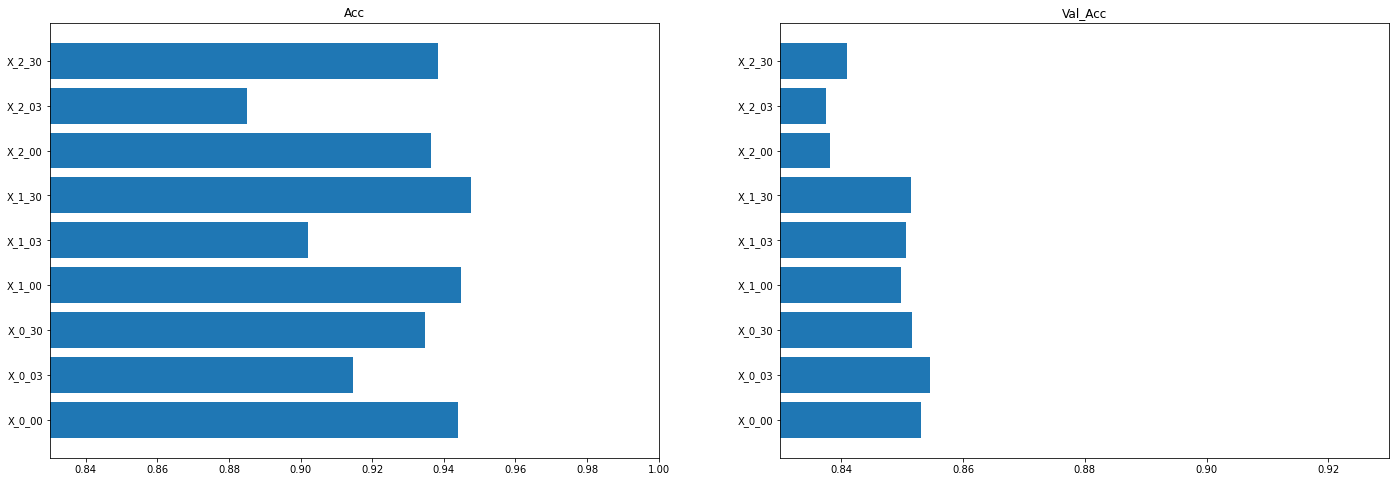

In [ ]:
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.barh(list_index, list_a)
plt.xlim(0.83,1)
plt.title('Acc')

plt.subplot(122)
plt.barh(list_index, list_v_a)
plt.xlim(0.83,0.93)
plt.title('Val_Acc')

plt.show()

**알 수 있는 사실**  
(1) 불용어 제거 : 지나치면 안하느니 못하다.  
(2) 낮은 빈도 수 단어 제거 : 적당히 하면 과적합을 줄일 수 있다.

### 예측해보기

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size_1_03, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))
  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_data_1_03, y_train_1_03, epochs=15, callbacks=[es], batch_size=64, validation_split=0.2)

Epoch 1/15
1787/1787 [==============================] - 214s 117ms/step - loss: 0.3917 - acc: 0.8219 - val_loss: 0.3573 - val_acc: 0.8430
Epoch 2/15
1787/1787 [==============================] - 192s 107ms/step - loss: 0.3307 - acc: 0.8538 - val_loss: 0.3469 - val_acc: 0.8485
Epoch 3/15
1787/1787 [==============================] - 203s 113ms/step - loss: 0.3036 - acc: 0.8664 - val_loss: 0.3393 - val_acc: 0.8514
Epoch 4/15
1787/1787 [==============================] - 194s 108ms/step - loss: 0.2809 - acc: 0.8769 - val_loss: 0.3550 - val_acc: 0.8488
Epoch 5/15
1787/1787 [==============================] - 193s 108ms/step - loss: 0.2567 - acc: 0.8891 - val_loss: 0.3649 - val_acc: 0.8486
Epoch 6/15
1787/1787 [==============================] - 194s 108ms/step - loss: 0.2309 - acc: 0.9018 - val_loss: 0.3934 - val_acc: 0.8451
Epoch 7/15
1787/1787 [==============================] - 195s 109ms/step - loss: 0.2069 - acc: 0.9137 - val_loss: 0.4283 - val_acc: 0.8416
Epoch 7: early stopping


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer_1_3.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
# 일반적인 긍정 리뷰
sentiment_predict('너무 재밌어요^^')

99.63% 확률로 긍정 리뷰입니다.



In [ ]:
# 일반적인 부정 리뷰
sentiment_predict('진짜 심각하네요...')

99.54% 확률로 부정 리뷰입니다.



In [ ]:
# 평론가 긍정 리뷰 : 이동진 - '그랜드 부다페스트 호텔'
sentiment_predict('지나온 적 없는 어제의 세계들에 대한 근원적 노스탤지어.')

79.12% 확률로 긍정 리뷰입니다.



In [ ]:
# 평론가 부정 리뷰 : 이동진 - '7광구'
sentiment_predict('소재만 있었지, 할 이야기 자체가 없었던 영화.')

88.59% 확률로 부정 리뷰입니다.



In [ ]:
# 비꼬기 리뷰
sentiment_predict('감독님은 이 영화 덕분에 만수무강하시겠네요 ^^')

68.93% 확률로 부정 리뷰입니다.

